# Lecture 7 - Dynamics of Epidemiological Models

## Contents
1. [Compartmental Models](#compartmental-models)
2. [Fixed Points and Bifurcations in an SIR Model](#sir-model)
3. [A Period Doubling Route to Chaos in an SEIR Model with Seasonal Forcing](#seir-model)
4. [Conclusion](#conclusion)
5. [Further Reading](#further-reading)

In [ ]:
using Pkg
Pkg.activate(; temp = true)
Pkg.add("DynamicalSystems")
Pkg.add("DifferentialEquations")
Pkg.add("CairoMakie")
Pkg.add("Printf")

In [2]:
using DynamicalSystems, CairoMakie, Printf

┌ Info: Precompiling DynamicalSystems [61744808-ddfa-5f27-97ff-6e42cc95d634]
└ @ Base loading.jl:1664


## 1. Compartmental Models <a class="anchor" id="compartmental-models"></a>

- Epidemiological models provide a mathematical framework for understanding the dynamics of infectious diseases. 


- Most epidemiological models are derived from within the generic framework of **compartmental models**.


- In a compartmental model, the ‘host’ population is partitioned according to its status of infection.


- For example, the canonical SIR model has three compartments:
  
    1. **Susceptible**: Individuals who are susceptible to the disease.  
    2. **Infectious**: Infected individuals, who are assumed infectious (i.e. they can infect susceptible individuals).  
    3. **Recovered**: Individuals who have been infected and are now removed from the possibility of being infected again (e.g. via lasting immunity).
    
    
- In this simplified model, individuals in the host population can "transition" from the susceptible to the infected state and subsequently from the infected to the recovered state.

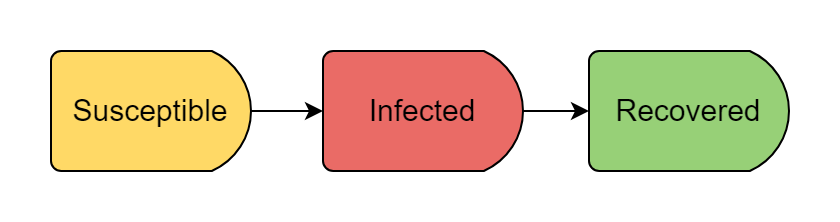
[Source](https://dl.acm.org/doi/fullHtml/10.1145/3449258.3449261)

- The dynamics of the epidemic are therefore determined by the **transition rates** of the host population between the three states (or compartments).


- In other words, we need a set of differential equations describing the rates of change of the number of individuals in each compartment - a dynamical system.

## 2. Fixed Points and Bifurcations in an SIR Model <a class="anchor" id="sir-model"></a>

- To derive the equations of motion for a simplified SIR model and investigate its dynamics, we will suppose that some infectious disease is present in the population which is transmitted from human to human and which confers lasting immunity after recovery. Examples of such a disease would be measles, mumps, and rubella.


- The model and parameters in this section are taken from the notebook [Dynamical Systems Analysis of Epidemiological Models](https://modelinginbiology.github.io/Dynamical-System-Analysis-of-Epidemiological-Models?loc=0), which accompanies the book [Modeling Life: The Mathematics of Biological Systems (Garfinkel et al. 2017)](https://link.springer.com/book/10.1007/978-3-319-59731-7).
    

- We first make some (highly idealised) assumptions about the transition rates between the compartments:


| Parameter | Description | Default Value | Units | Comment |
| :- | :- | :- | :- | :- |
| $\sigma$ | Birth rate | 10 | births / day | Newborns become susceptible immediately |
| $d$ | Normal death rate | 0.01 | deaths / person / day | Average healthy lifespan = $1/d$ |
| $\delta$ | Infected death rate | 0.02 | deaths / person / day ||
| $c$ | Encounter rate | 1 | encounters / person / day ||
| $\beta$ | Probability of infection per encounter | 0.05 | infections / encounter ||
| $\nu$ | Infection recovery rate | 0.7 | recoveries / person / day | Average infection duration = $1 / \nu$ |


- We can now write down a set of coupled ODEs:

$$
\begin{aligned}
\frac{dS}{dt} & = \sigma - dS - c\beta \frac{SI}{S + I + R} \\[3pt]
\frac{dI}{dt} & = c\beta \frac{SI}{S + I + R} - (\delta + \nu)I \\[3pt]
\frac{dR}{dt} & = \nu I - dR
\end{aligned}
$$


- With the equations of motion in hand, we can investigate the dynamics of this system.

### 2.1. Fixed Points

- What are the fixed points of this SIR model?


- Setting $\dot S = \dot I = \dot R = 0$, we find that all of the derivatives vanish at $(S, I, R) = (\frac{\sigma}{d},0,0)$. This trivial fixed point is called a **disease-free equilibrium (DFE)** point, since $I = 0$.


- In fact, for these parameter values, it can also be shown that it is the only fixed point of this system and it is stable.


- Let's investigate numerically.

In [3]:
function SIR(u, p, t)
    S, I, R = u
    σ, d, c, δ, ν, β = p
    
    dS = σ - d * S - c * β * S * I / (S + I + R)
    dI = c * β * S * I / (S + I + R) - (δ + ν) * I
    dR = ν * I - d * R
    
    return SVector{3}(dS, dI, dR)
end

SIR (generic function with 1 method)

In [4]:
function plot_SIR(f; β = 0.05, T = 1000.0, Δt = 0.1, u0 = 1000 * rand(3))
    # Default parameters
    σ = 10
    d = 0.01
    c = 1
    δ = 0.02
    ν = 0.7
    p = [σ, d, c, δ, ν, β]
    
    # Integrate the dynamical system
    ds = ContinuousDynamicalSystem(f, u0, p)
    tr = trajectory(ds, T; Δt)
    S, I, R = columns(tr)
    
    @printf "Initial conditions: S(0) = %4i, I(0) = %4i, R(0) = %4i\n" u0[1] u0[2] u0[3]
    @printf "Final state:        S(T) = %4i, I(T) = %4i, R(T) = %4i" S[end] I[end] R[end]
    
    # Plotting
    fig = Figure(resolution = (1200, 600))
    ax = Axis(fig[1, 1], xlabel = "days", title = @sprintf "β = %0.2f" β)
    times = Δt * collect(1:length(S))
    lines!(ax, times, S, linewidth = 3, label="S")
    lines!(ax, times, I, linewidth = 3, label="I")
    lines!(ax, times, R, linewidth = 3, label="R")
    axislegend()
    fig
end

plot_SIR (generic function with 1 method)

Initial conditions: S(0) =  429, I(0) =  124, R(0) =  290
Final state:        S(T) = 1000, I(T) =    0, R(T) =    0

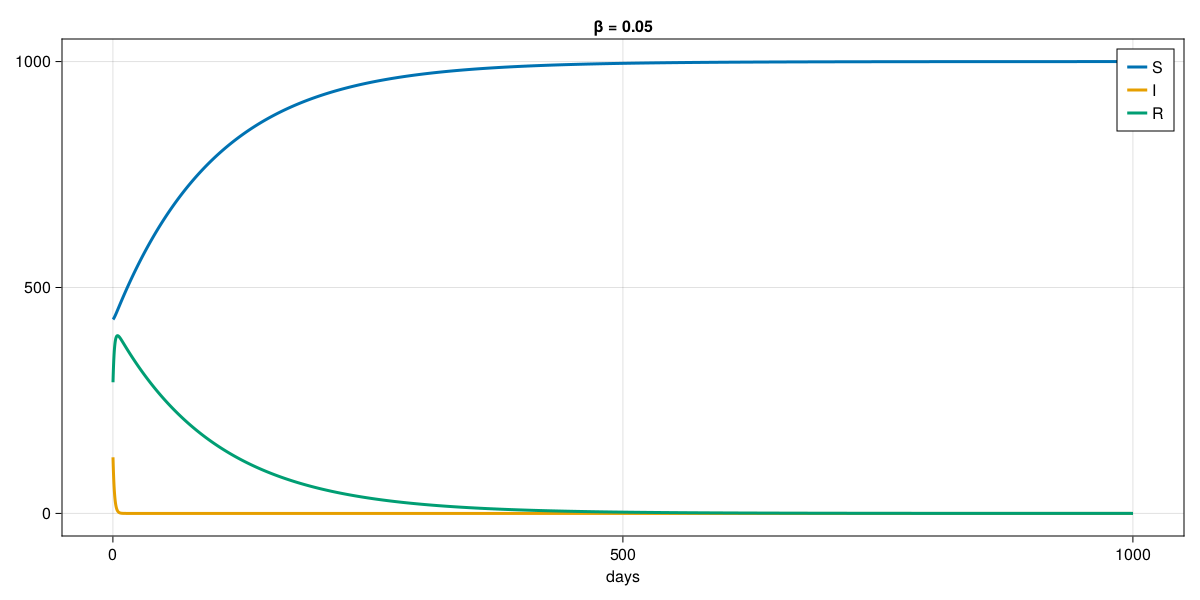

In [5]:
plot_SIR(SIR, T = 1000.0)

- For the default parameters, we observe the predicted disease-free equilibrium at $(S, I, R) = (\frac{\sigma}{d},0,0)$.


- What if we increase the probability of infection per encounter? Say, increase $\beta$ from $0.05$ to $0.9$.


- The trivial disease-free equilibrium still exists at $(S, I, R) = (\frac{\sigma}{d},0,0)$. However, it is now unstable.


- In addition, for $\dot S = \dot I = \dot R = 0$ **and** $I \neq 0$, it can be shown that there is another fixed point at approximately $(S, I, R) = (780,3,197)$. This is an **endemic equilibrium (EE)** point and it is stable.


- What do the simulations say?


Initial conditions: S(0) =  788, I(0) =  899, R(0) =  535
Final state:        S(T) =  794, I(T) =    3, R(T) =  201

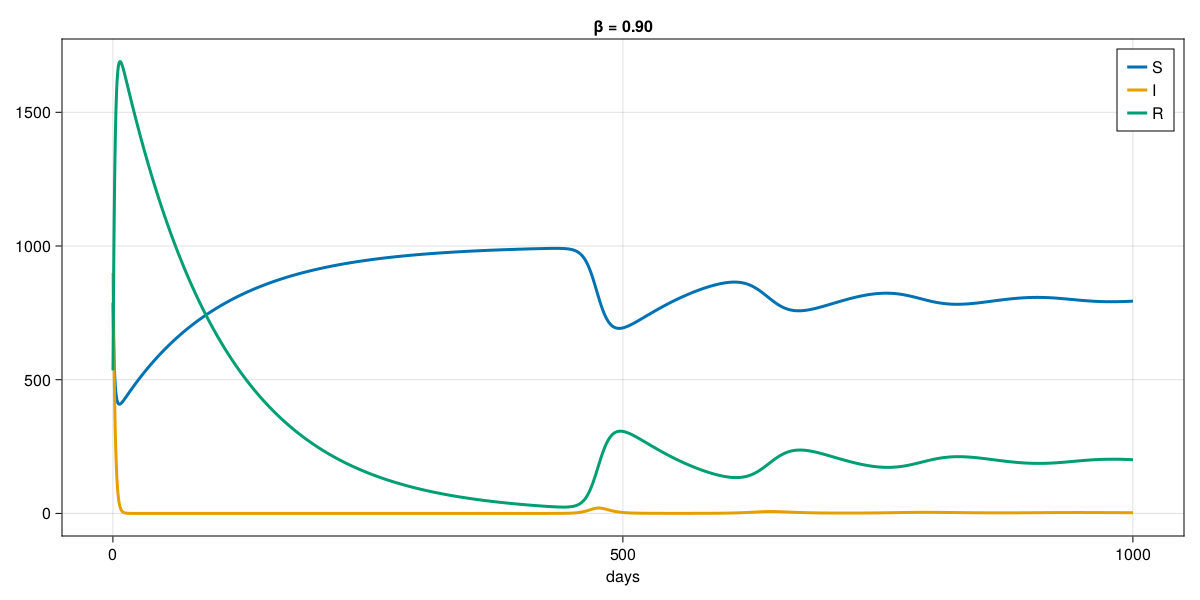

In [6]:
plot_SIR(SIR; β = 0.9, T = 1000.0)

- After increasing $\beta$, we now see oscillations followed by convergence to the endemic equilibrium point around $I = 3$, which appears to be stable.


- What we have observed after changing the parameter $\beta$ is a qualitative change in the behaviour of the dynamical system, i.e. a **bifurcation**. Let's try to examine this behaviour more systematically with a bifurcation diagram.

### 2.2. Bifurcation Diagram

- We will examine the qualitative behaviour of the system as a function of the parameter $R_{0}$, the **basic reproductive number**, which depends linearly on $\beta$,

$$R_0 = \frac{c\beta}{\delta + \nu}.$$


- $R_0$ measures the average number of people infected by each infected person.


- Thus, let's observe the fixed points of the system for varying values of $R_0$.

In [7]:
function plot_SIR_bifurcation_diagram(R₀_range; u0 = 1000 * rand(3))
    # Default parameters
    σ = 10
    d = 0.01
    c = 1
    δ = 0.02
    ν = 0.7    
        
    fig = Figure(resolution = (1000, 600))
    ax = Axis(fig[1, 1], xlabel = "R₀", ylabel = "I", title = "SIR Bifurcation Diagram")

    for R₀ = R₀_range
        β = R₀ * (δ + ν) / c
        p = [σ, d, c, δ, ν, β]
        ds = ContinuousDynamicalSystem(SIR, u0, p)
        tr = trajectory(ds, 10000.0)
        S, I, R = tr[end]
        scatter!(ax, [R₀], [I], color = R₀ < 1 ? :blue : :red)
    end
    
    dfe = MarkerElement(color = :blue, marker = '●', markersize = 12)
    ee = MarkerElement(color = :red, marker = '●', markersize = 12)
    Legend(fig[1, 2], [dfe, ee], ["Disease-Free Equilibrium", "Endemic Equilibrium"])
    return fig
end

plot_SIR_bifurcation_diagram (generic function with 1 method)

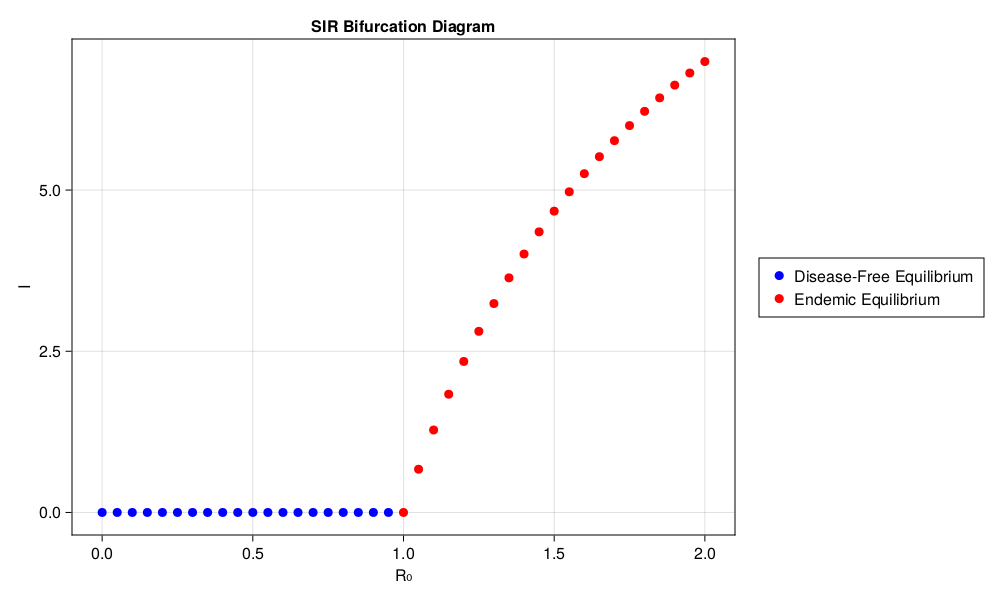

In [8]:
plot_SIR_bifurcation_diagram(0:0.05:2)

- We clearly observe a bifurcation at $R_0 = 1$. For $R_0 < 1$, when each individual infects less than one other, on average, the infection goes extinct. For $R_0 > 1$, the infection becomes endemic.


- Note that the DFE still exists for $R_0 > 1$, but it is unstable.


- A linear stability analysis of the DFE and EE fixed points is also possible, offering a more rigorous determination of their stability. See the aforementioned [notebook](https://modelinginbiology.github.io/Dynamical-System-Analysis-of-Epidemiological-Models?loc=0) for more. 

### 2.3. Phase Portraits

- Not only does the system converge to the endemic equilibrium point for $R_0 > 1$, it appears to oscillate as it does so.

Initial conditions: S(0) =  826, I(0) =  481, R(0) =  705
Final state:        S(T) =  793, I(T) =    3, R(T) =  201

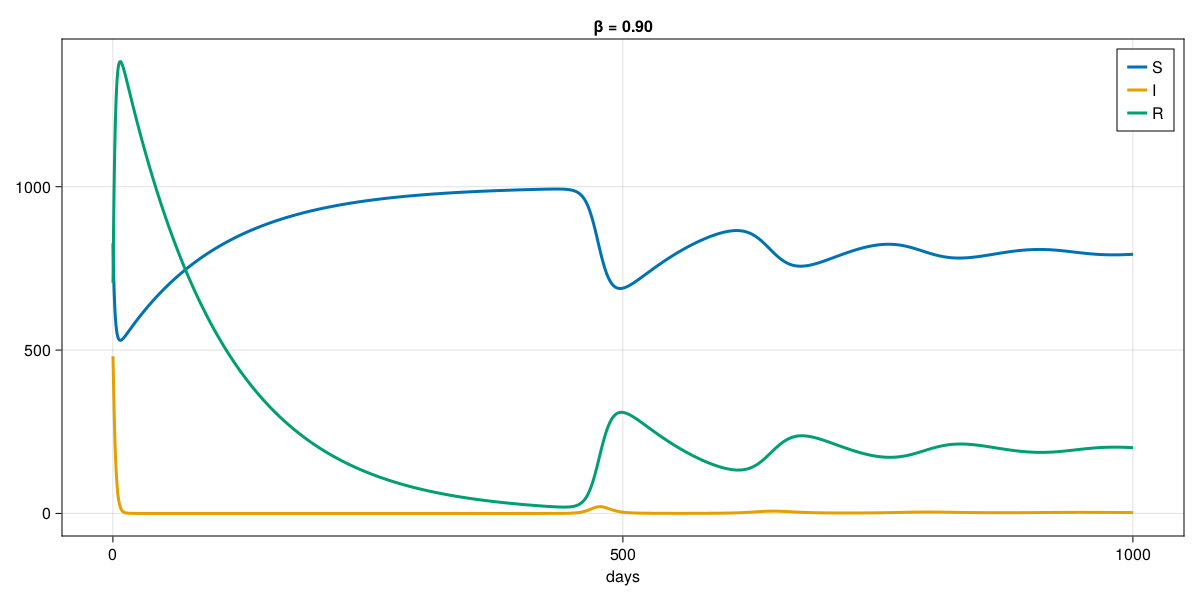

In [9]:
plot_SIR(SIR; β = 0.9)

- Let's examine the trajectory of the system in phase space as it approaches equilibrium.

In [10]:
function plot_SIR_phase_diagram(; β = 0.9, pop = 1000)
    # Model parameters
    σ = 10
    d = 0.01
    c = 1
    δ = 0.02
    ν = 0.7
    p = [σ, d, c, δ, ν, β]
    
    u0 = [pop - 1, 1.0, 0.0]  # Start with just 1 infected individual in the population
    
    fig = Figure(resolution = (600, 600))
    ax = Axis(fig[1, 1], xlabel = "S", ylabel = "I", title = "Phase Portrait for the SIR Model")
    
    ds = ContinuousDynamicalSystem(SIR, u0, p)
    tr = trajectory(ds, 1000)
    S, I, R = columns(tr)
    lines!(ax, S, I, xlabel="S", ylabel="I")
    
    fig
end

plot_SIR_phase_diagram (generic function with 1 method)

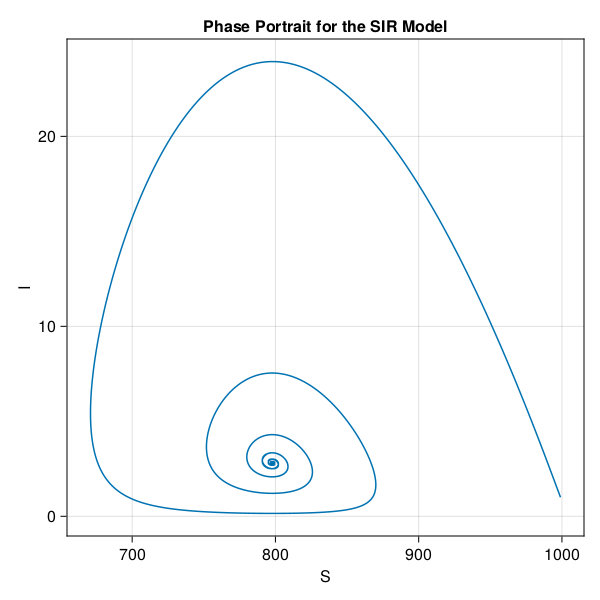

In [11]:
plot_SIR_phase_diagram(β = 0.9)

- Interestingly, we observe **recurring waves of infection** as the system approaches the endemic equilibrium point.


- These oscillations are purely in response to the **dynamics** of the system. Remember, all of the parameters are constant during the integration, so there is no seasonality and no interventions such as lockdowns or treatment.


- How does it look if we increase the size of the initial population?

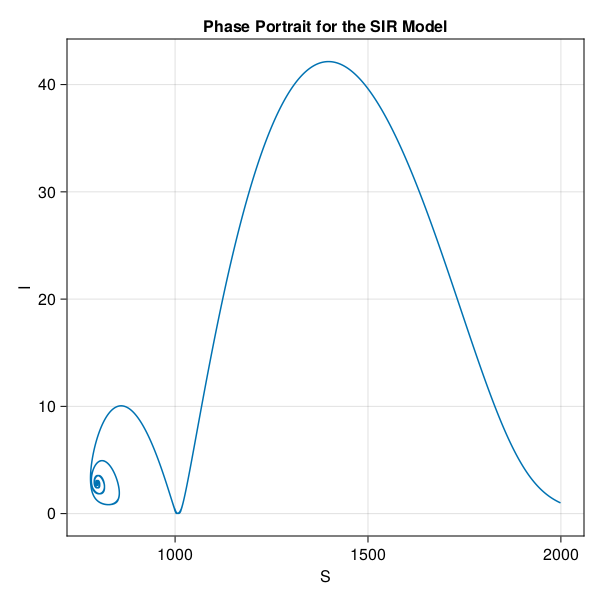

In [12]:
plot_SIR_phase_diagram(pop = 2000)

- Once again, we observe an initial large wave of infection, followed by the apparent extinction of the disease, followed by its reemergence en route to endemicity.

## 3. A Period Doubling Route to Chaos in an SEIR Model with Seasonal Forcing <a class="anchor" id="seir-model"></a>

- We now extend our simple SIR model to include an additional compartment for **exposed** individuals - those who have been infected but are not yet infectious.


- The model and parameters in this section are taken from the paper [Seasonality and period-doubling bifurcations in an epidemic model (Aron & Schwartz 1984)](https://doi.org/10.1016/S0022-5193(84)80150-2), and are considered typical for a measles outbreak in an urban area.


- We make the following assumptions:

    1. There are equal birth and death rates, $\mu$, along with no migration, such that the total population $S + E + I + R = N$ remains constant. This is a reasonable simplifying assumption in cases where the dynamics of the epidemic unfold on timescales much faster than demographic changes. 
    2. Exposed individuals become infectious with a mean rate $\alpha$, so that the mean latent period is $1/\alpha$.
    3. Infected individuals recover with a mean rate $\gamma$, so that the mean infectious period is $1/\gamma$.
    4. Recovered individuals are permanently immune.


- In addition, we introduce some other key differences with the SIR model we studied earlier:

    - We scale our model variables by the (constant) total population $N$, such that $S$, $E$, $I$, and $R$ now refer to the **proportion** of the total population in each compartment and $S + E + I + R = 1$.  
    - The contact rate $\beta$ now incorporates both the probability of an encounter between a susceptible and an infectious person as well as the probability that that encounter leads to an transmission.
    - We additionally introduce **annual seasonality** in the contact rate $\beta$, in the form

  $$\beta(t) = \beta_0(1 + \beta_1 cos(2\pi t)),$$

where $\beta_0 > 0$ is the mean contact rate and $0 \leq \beta_1 \leq 1$ controls the degree of seasonality.


- We can then straightforwardly write down a system of coupled ODEs for the dynamics of the system,

$$
\begin{aligned}
\frac{dS}{dt} & = \mu - \beta(t)SI - \mu S \\[3pt]
\frac{dE}{dt} & = \beta(t)SI - (\mu + \alpha)E \\[3pt]
\frac{dI}{dt} & = \alpha E - (\mu + \gamma)I,
\end{aligned}
$$

with the equation for $R$ determined from the fact that $S + E + I + R = 1$ and therefore $\dot S + \dot E + \dot I + \dot R= 0$.


- For a discussion and derivation of the transmission term $\beta(t)SI$, see [Modeling Infectious Diseases in Humans and Animals (Keeling & Rohani 2008)](https://press.princeton.edu/books/hardcover/9780691116174/modeling-infectious-diseases-in-humans-and-animals). The form given here corresponds to frequency dependent (mass-action) transmission, in which the number of contacts is independent of the total population size.


- The parameters we will use are summarised in the following table:

| Parameter | Description | Default Value | Units | Comment |
| :- | :- | :- | :- | :- |
| $\mu$ | Birth / death rate | 0.02 | 1 / year ||
| $\alpha$ | Rate at which exposed become infectious | 35.84 | 1 / year |Mean latent period is $1/\alpha$|
| $\gamma$ | Recovery rate | 100 | 1 / year |Mean infectious period is $1/\gamma$|
| $\beta_0$ | Contact rate | 1800 | 1 / year ||
| $\beta_1$ | Degree of seasonality | $0 \leq \beta_1 \leq 1$ | dimensionless | We will vary this.|


- Let's immediately set up the model and observe how the dynamics depend on $\beta_1$.

In [13]:
using DifferentialEquations  # I'll use DifferentialEquations.jl here for more control over the integration

In [14]:
function SEIR_seasonal!(du, u, p, t)
    S, E, I, R = u
    μ, α, γ, β₀, β₁ = p
    
    β = β₀ * (1 + β₁ * cos(2π * t))
        
    du[1] = μ - β * S * I - μ * S
    du[2] = β * S * I - (μ + α) * E
    du[3] = α * E - (μ + γ) * I
    du[4] = -1 * (du[1] + du[2] + du[3])
    
    return nothing
end

SEIR_seasonal! (generic function with 1 method)

In [15]:
function plot_SEIR_seasonal(; β₁, T = 10.0, Ttr = 1000.0, u0 = rand(4))
    # Model parameters
    μ  = 0.02
    α  = 35.84
    γ  = 100
    β₀ = 1800
    p = [μ, α, γ, β₀, β₁]
    
    # Initial conditions
    u0 /= sum(u0)  # Normalise so that S + E + I + R = 1
    @printf "Initial conditions: S(0) = %.2f, E(0) = %.2f, I(0) = %.2f, R(0) = %.2f" u0[1] u0[2] u0[3] u0[4]

    # Integration parameters
    cb = PositiveDomain(zeros(4), abstol = 1e-21)  # Callback to ensure the solution remains positive

    # Transient integration
    tol = 1e-15
    prob_transient = ODEProblem(SEIR_seasonal!, u0, (0.0, Ttr), p)
    sol_transient = solve(prob_transient, Vern9(), abstol = tol, reltol = tol, callback = cb)

    # Actual integration
    u1 = sol_transient[end]
    prob = ODEProblem(SEIR_seasonal!, u1, (0.0, T), p)
    sol = solve(prob, Vern9(), saveat = 0.01, abstol = tol, reltol = tol, callback = cb)

    # Plotting
    S = sol[1, :]
    I = sol[3, :]
    fig = Figure(resolution = (1200, 600))
    ax1 = Axis(fig[1, 1], xlabel = "year", ylabel = "-log(I)")
    ax2 = Axis(fig[1, 2], xlabel = "-log(S)", ylabel = "-log(I)")
    lines!(ax1, sol.t, -1 * log.(I), linewidth = 3)
    lines!(ax2, -1 * log.(S), -1 * log.(I), linewidth = 3)
    fig
end

plot_SEIR_seasonal (generic function with 1 method)

In [16]:
u0 = [0.99, 0.0, 0.01, 0.0]  # Start with 1% of the population infectious and 99% susceptible

4-element Vector{Float64}:
 0.99
 0.0
 0.01
 0.0

Initial conditions: S(0) = 0.99, E(0) = 0.00, I(0) = 0.01, R(0) = 0.00

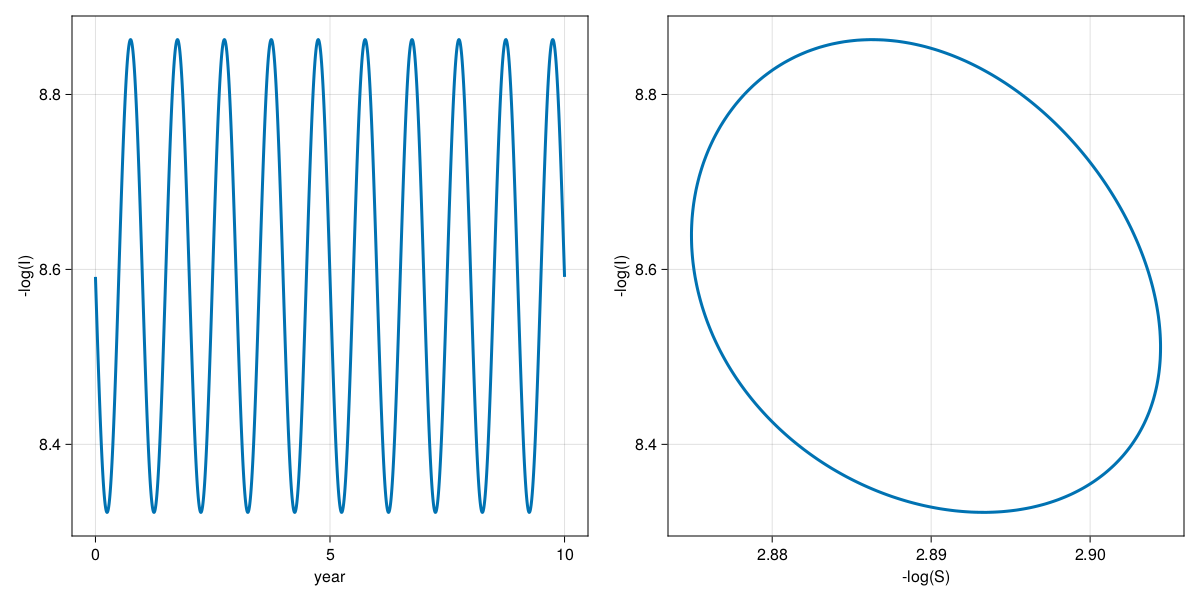

In [17]:
plot_SEIR_seasonal(β₁ = 0.05, T = 10, u0 = u0)

- For a moderate degree of seasonality $\beta_1$, we observe a stable limit cycle and annual waves of infection $I$.


- What happens as we increase $\beta_1$?

Initial conditions: S(0) = 0.99, E(0) = 0.00, I(0) = 0.01, R(0) = 0.00

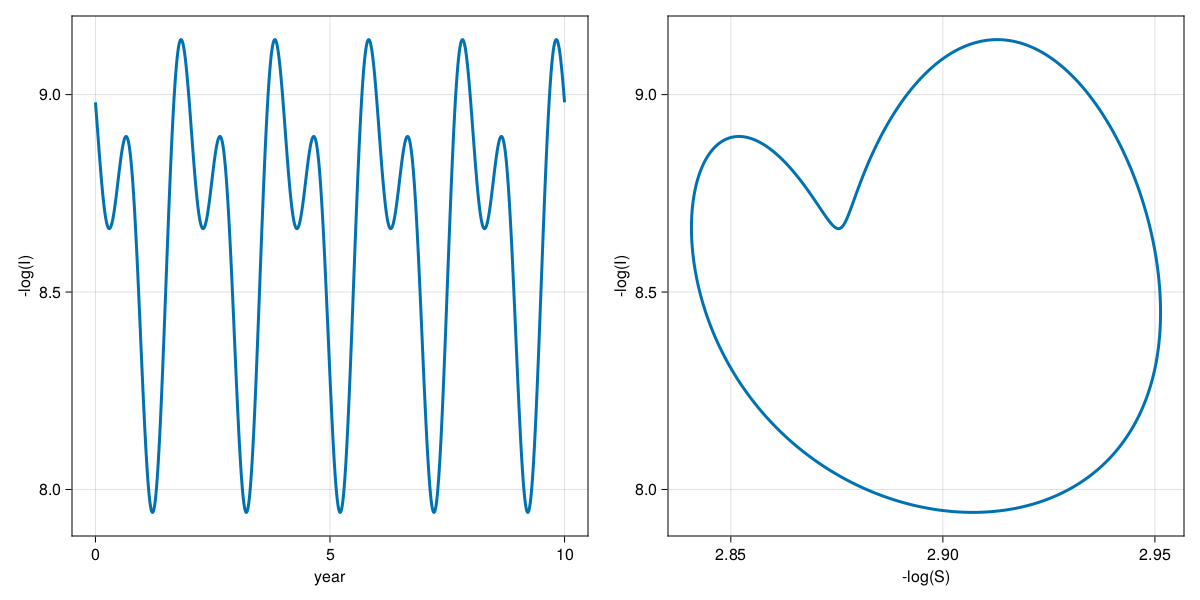

In [18]:
plot_SEIR_seasonal(β₁ = 0.06, T = 10, u0 = u0)

- We observe a bifurcation, in this case a distinct **period doubling** and the emergence of a new (stable) limit cycle. In fact, such a biennial cycle, with alternating years of high and low levels of infection, is typical of measles.


- Let's increase $\beta_1$ further.

Initial conditions: S(0) = 0.99, E(0) = 0.00, I(0) = 0.01, R(0) = 0.00

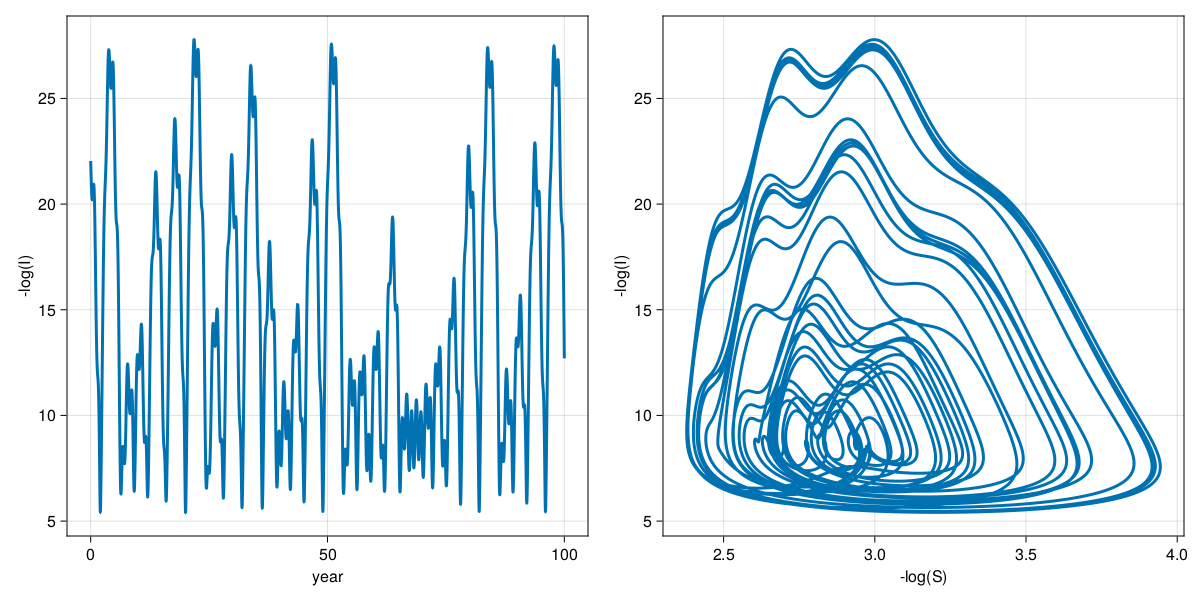

In [19]:
plot_SEIR_seasonal(β₁ = 0.28, T = 100, u0 = u0)

- After multiple period-doubling bifurcations, we observe the onset of chaos around $\beta_1$ = 0.28.


- In this apparently chaotic regime, do we observe sensitive dependence on initial conditions? 

In [20]:
function plot_SEIR_seasonal_multiple_trajectories(;β₁, T = 50.0, u0 = [rand(4), rand(4)])
    # Model parameters
    μ = 0.02
    α = 35.84
    γ = 100
    β₀ = 1800
    p = [μ, α, γ, β₀, β₁]
    
    # Initial conditions
    @. u0 = u0 / sum(u0)  # Normalise so that S + E + I + R = 1

    # Integration parameters
    cb = PositiveDomain(zeros(4), abstol = 1e-21)  # Callback to ensure the solution remains positive

    # Integration
    tol = 1e-15
    prob_1 = ODEProblem(SEIR_seasonal!, u0[1], (0.0, T), p)
    sol_1 = solve(prob_1, Vern9(), saveat = 0.01, abstol = tol, reltol = tol, callback = cb, maxiters = 1e7)
    prob_2 = ODEProblem(SEIR_seasonal!, u0[2], (0.0, T), p)
    sol_2 = solve(prob_2, Vern9(), saveat = 0.01, abstol = tol, reltol = tol, callback = cb, maxiters = 1e7)

    # Plotting
    S1, I1 = sol_1[1, :], sol_1[3, :]
    S2, I2 = sol_2[1, :], sol_2[3, :]
    fig = Figure(resolution = (1200, 600))
    ax1 = Axis(fig[1, 1], xlabel = "year", ylabel = "-log(I)")
    ax2 = Axis(fig[1, 2], xlabel = "-log(S)", ylabel = "-log(I)")
    lines!(ax1, sol_1.t, -1 * log.(I1), linewidth = 3, linecolor = :red)
    lines!(ax1, sol_2.t, -1 * log.(I2), linewidth = 3, linecolor = :blue)
    lines!(ax2, -1 * log.(S1), -1 * log.(I1), linewidth = 3, linecolor = :red)
    lines!(ax2, -1 * log.(S2), -1 * log.(I2), linewidth = 3, linecolor = :blue)
    fig
end

plot_SEIR_seasonal_multiple_trajectories (generic function with 1 method)

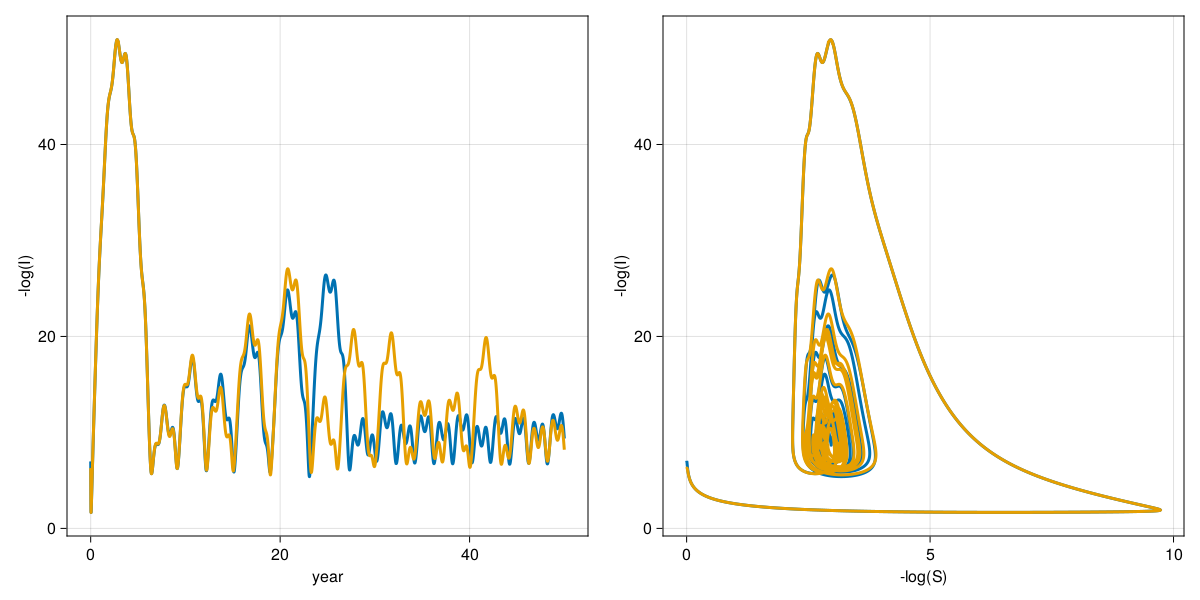

In [21]:
plot_SEIR_seasonal_multiple_trajectories(β₁ = 0.28, u0 = [[0.999, 0.0, 0.001, 0.0], [0.998, 0.0, 0.002, 0.0]])

- As expected for chaotic dynamics, trajectories which are initially close together subsequently diverge.


- What's the Lyapunov exponent?

In [22]:
function get_lyapunov_exponent(; β₁)
    μ = 0.02
    α = 35.84
    γ = 100
    β₀ = 1800
    p = [μ, α, γ, β₀, β₁]

    ds = ContinuousDynamicalSystem(SEIR_seasonal!, [0.99, 0.0, 0.01, 0.0], p)

    return lyapunov(ds, 1000.0, Ttr = 100.0, diffeq = (alg = Vern9(), abstol = 1e-15, reltol = 1e-15))
end

get_lyapunov_exponent (generic function with 1 method)

In [24]:
get_lyapunov_exponent(β₁ = 0.28)

0.31516743164412775

## 4. Conclusion <a class="anchor" id="conclusion"></a>

- In this lecture we observed rich dynamics arising from simple epidemiological models:

    1. Stable and unstable fixed points.
    2. Bifurcations.
    3. Oscillations leading to recurring waves of infection.
    4. Limit cycles.
    5. A period doubling route to chaos.
    6. Sensitive dependence on initial conditions.


- While these models are simplified, their dynamics nonetheless have implications for the prediction and control of real epidemics.


- In today's exercise you will derive further generalisations of these models and investigate their dynamics using the tools you've learned so far in this lecture series.

## 5. Further Reading <a class="anchor" id="further-reading"></a>
1. Used in this lecture:  
    a. [Dynamical Systems Analysis of Epidemiological Models](https://modelinginbiology.github.io/Dynamical-System-Analysis-of-Epidemiological-Models?loc=0)  
    b. [Seasonality and period-doubling bifurcations in an epidemic model (Aron & Schwartz 1984)](https://doi.org/10.1016/S0022-5193(84)80150-2)
2. Epidemiological models:  
    a. [Wikipedia](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology)  
    b. [Mathematical Models in Epidemiology (Brauer et al. 2019)](https://link.springer.com/book/10.1007/978-1-4939-9828-9)  
    c. [Modeling Life: The Mathematics of Biological Systems (Garfinkel et al. 2017)](https://link.springer.com/book/10.1007/978-3-319-59731-7)  
    d. [Modeling Infectious Diseases in Humans and Animals (Keeling & Rohani 2008)](https://press.princeton.edu/books/hardcover/9780691116174/modeling-infectious-diseases-in-humans-and-animals)  